1. cell type 
2. coarse cell type

check elbo between wrong and correct ones

# Load packages and data

In [1]:
%cd ../RADOM

# Load before numpy to restrict its usage of cores, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

from inference import Trajectory
from preprocess import *
from plotting import *

/home/mffang/workspace/Poisson-regression/RADOM


In [2]:
import scanpy as sc
import scvelo as scv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cmasher as cmr
from tqdm import tqdm

## Load data

h5 files can be downloaded as following:
```
#!wget --directory-prefix=../data/Barile/ http://bioinformatics.stemcells.cam.ac.uk/mb2338/adata_for_velocity_mouse.h5
#!wget --directory-prefix=../data/Barile/ http://bioinformatics.stemcells.cam.ac.uk/mb2338/adata_human_for_velocity.h5
```

In [4]:
data_dir = "../data/Barile/"

In [5]:
data = sc.read(data_dir+'adata_for_velocity_mouse.h5')
gene_names = data.var_names
x = data.obsm['X_pca']
x[:,0] *= -1
data

AnnData object with n_obs × n_vars = 9815 × 3434
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster', 'cell_velocyto_loom'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'celltype_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [6]:
cell_types = ['Blood progenitors 1','Blood progenitors 2','Erythroid1','Erythroid2', 'Erythroid3']
stages = ['E7.0', 'E7.25', 'E7.5', 'E7.75', 'E8.0', 'E8.25', 'E8.5']

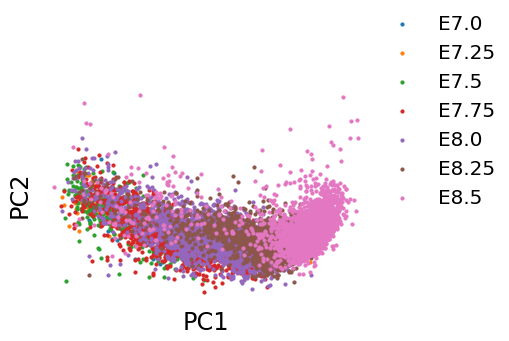

In [7]:
fig, ax = plt.subplots(1,1)
for i,stage in enumerate(stages):
    idx = data.obs['stage'].isin([stage])
    im=ax.scatter(x[idx,0],x[idx,1],s=10,label=stage);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
ax.legend(loc=(1,0.4),fontsize=20,frameon=False)
ax.set_xlabel('PC1',fontsize=24)
plt.xticks([]);
plt.yticks([]);

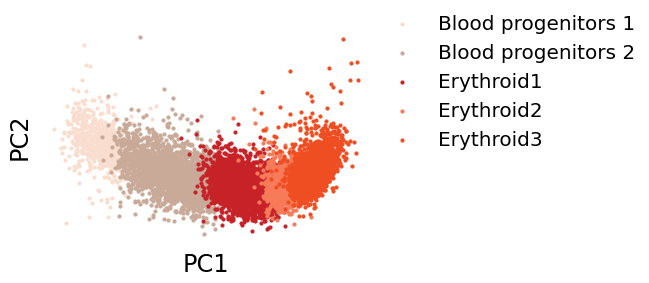

In [8]:
fig, ax = plt.subplots(1,1)
for i,cell_type in enumerate(cell_types):
    idx = data.obs['celltype'].isin([cell_type])
    im=ax.scatter(x[idx,0],x[idx,1],c=data.uns['celltype_colors'][i],s=10,label=cell_type);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
ax.legend(loc=(1,0.4),fontsize=20,frameon=False)
ax.set_xlabel('PC1',fontsize=24)
plt.xticks([]);
plt.yticks([]);

In [9]:
from matplotlib.colors import LinearSegmentedColormap
cmap_cluster = LinearSegmentedColormap.from_list("my_cmap", data.uns['celltype_colors'], N=5)

# Top 100 genes

In [17]:
import numpy as np
from scipy.special import gammaln
from scipy.stats import chi2, poisson
import pandas as pd
import matplotlib.pyplot as plt
import anndata
pd.options.mode.chained_assignment = None  # default='warn'

def entropy(X):
    """
    Shannon entropy of the empirical distributions for each gene
    """
    n,p,s = X.shape
    entropy = np.zeros(p)
    for j in range(p):
        for k in range(s):
            x=X[:,j,k]
            value,counts = np.unique(x, return_counts=True)
            norm_counts = counts / counts.sum()
            entropy[j] -= (norm_counts * np.log(norm_counts)).sum()
    return entropy


def select_genes(adata,r=None,n_genes=30):
    """
    Perform G test of Poisson fits and select n_genes with highest G-test statistic
    """
    n = adata.n_obs
    idx = (adata.layers["unspliced"].toarray().mean(0) > 0) & (adata.layers["spliced"].toarray().mean(0) > 0)
    X=np.zeros((n,idx.sum(),2))
    X[:,:,0]=adata.layers["unspliced"][:,idx].toarray()
    X[:,:,1]=adata.layers["spliced"][:,idx].toarray()
    Y = np.mean(X,axis=0,keepdims=True)
    if r is None:
        logL = np.sum(poisson.logpmf(k=X,mu=Y),axis=(0,2))
    elif np.shape(r)==(n,):
        r /= r.mean()
        logL = np.sum(poisson.logpmf(k=X,mu=r[:,None,None]*Y),axis=(0,2))
    else:
        r = adata.layers["unspliced"].toarray().sum(1) + adata.layers["spliced"].toarray().sum(1)
        r /= r.mean()
        logL = np.sum(poisson.logpmf(k=X,mu=r[:,None,None]*Y),axis=(0,2))
    #logL = np.sum(X*np.log(r[:,None,None]*Y)-r[:,None,None]*Y-gammaln(X+1),axis=(0,2))
    
    negG = logL + n*entropy(X)
    p_value = 1-chi2.cdf(-2*negG,df=n-1)
    selected_genes = adata.var_names[idx][np.argsort(negG)[:n_genes]]
    adata.var['e logL'] = np.nan
    adata.var['Poisson logL'] = np.nan
    adata.var['p value'] = np.nan
    adata.var['e logL'][idx] = -n*entropy(X)
    adata.var['Poisson logL'][idx] = logL
    adata.var['p value'][idx] = p_value
    
    ## return data X and gene_names
    idx = [np.where(adata.var_names == gene)[0][0] for  gene in selected_genes]
    X=np.zeros((n,len(idx),2))
    X[:,:,0]=adata.layers["unspliced"][:,idx].toarray()
    X[:,:,1]=adata.layers["spliced"][:,idx].toarray()

    return X, selected_genes

In [18]:
X, fitted_genes = select_genes(data,r=None,n_genes=100)

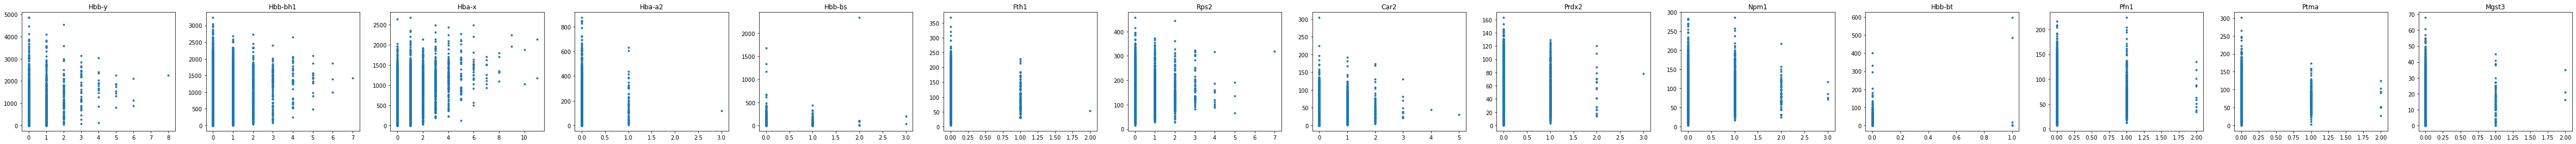

In [19]:
plot_p=14
fig, ax = plt.subplots(1,plot_p,figsize=(6*plot_p,4))
for j in range(plot_p):
    ax[j].plot(X[:,j,0],X[:,j,1],'.')
    ax[j].set_title(fitted_genes[j])

In [20]:
plot_genes = ['Smim1', 'Hba-x','Abcg2','Cnn3','Scube2']
plot_idx = [np.where(fitted_genes==gene)[0] for gene in plot_genes]
plot_idx = np.concatenate(plot_idx).ravel()
print(fitted_genes[plot_idx])

Index(['Smim1', 'Hba-x'], dtype='object', name='index')


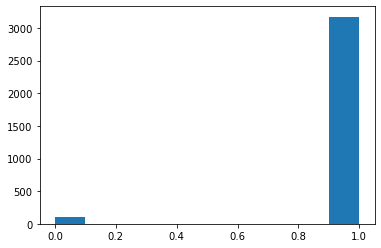

In [72]:
plt.hist(data.var['p value']);

# Murk genes

**Filter genes**

Because the unspliced counts are so low, the ratio of beta/gamma has to be very large. In such scenario, there is time scale seperation and phase plot looks like a (part of) rectangle.

In [9]:
murk_genes = list(pd.read_csv(data_dir+'murk_genes_mouse.txt',sep=" ",header=None)[0])
marker_genes = ["Gata1"]
fitted_genes_mask = (data.var_names.isin(murk_genes)) \
                    & (data.layers["unspliced"].toarray().mean(axis=0)>0.01) \
                    & (data.layers["spliced"].toarray().mean(axis=0)>0.01) \
                    & (np.abs(np.log10(data.layers["unspliced"].toarray().mean(axis=0)/data.layers["spliced"].toarray().mean(axis=0)))<=2) 
fitted_genes_mask = fitted_genes_mask | (data.var_names.isin(marker_genes))
fitted_genes = gene_names[fitted_genes_mask]
print(fitted_genes_mask.sum())

40


**Slice the count matrix and get X**

In [10]:
n,p = data[:,fitted_genes_mask].X.shape
X = np.zeros((n,p,2))
X[:,:,0]= data.layers["unspliced"].toarray()[:,fitted_genes_mask]
X[:,:,1]= data.layers["spliced"].toarray()[:,fitted_genes_mask]

In [13]:
plot_genes = ['Smim1', 'Hba-x','Abcg2','Cnn3','Scube2']
plot_idx = [np.where(fitted_genes==gene)[0] for gene in plot_genes]
plot_idx = np.concatenate(plot_idx).ravel()
print(fitted_genes[plot_idx])

Index(['Smim1', 'Abcg2'], dtype='object', name='index')


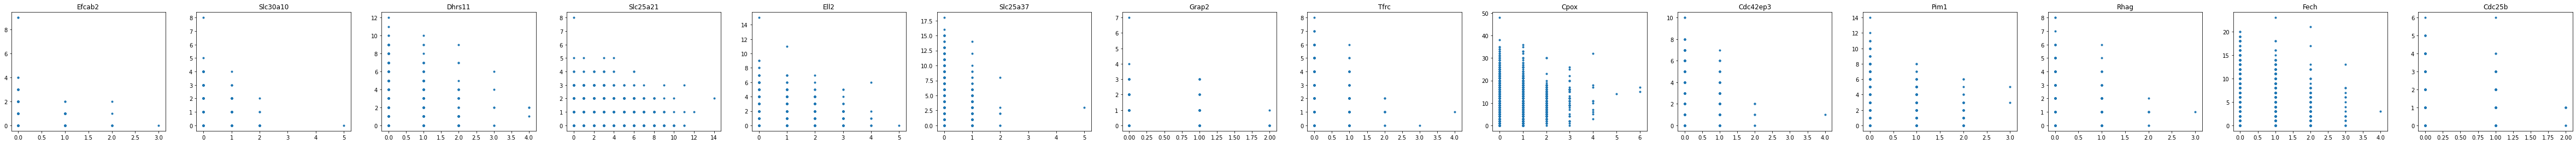

In [11]:
plot_p=14
fig, ax = plt.subplots(1,plot_p,figsize=(6*plot_p,4))
for j in range(plot_p):
    ax[j].plot(X[:,j,0],X[:,j,1],'.')
    ax[j].set_title(fitted_genes[j])

# Fitting

In [84]:
def estimate_r(adata):
    r = adata.X.toarray().sum(1)
    return r/r.mean()

In [85]:
elbos = {}
params={'r':estimate_r(data),"lambda_tau":0,"lambda_a":0}

In [86]:
estimate_r(data).shape

(9815,)

## Fine cluster

In [121]:
m=100
t_grids=np.linspace(0,2,m)
weight0 = np.ones((data.n_obs,m))
for i,cell_type in enumerate(cell_types):
    idx = data.obs["celltype"].isin([cell_type])
    weight0[idx,int(i*m/5):int((i+1)*m/5)] += 1
weight0=weight0/weight0.sum(axis=1,keepdims=True)
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
Q0 = weight0[:,None]

In [122]:
topo = np.array([[0,1,2]])
tau = (0,24,48) # ~48 hours
traj = Trajectory(topo, tau, model="two_species_ss",verbose=1)
traj = traj.fit(X,warm_start=True,fit_tau=False,params=params,Q=Q0,parallel=True,n_threads=10,epoch=10)

fitting with warm start


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


In [123]:
traj.tau

array([ 0., 24., 48.])

In [124]:
traj.theta[0]

array([1.13795656e-06, 3.35215612e-06, 7.56697823e-01, 5.12550370e+01,
       1.00000000e-04])

In [125]:
elbos['cf'] = traj.elbos

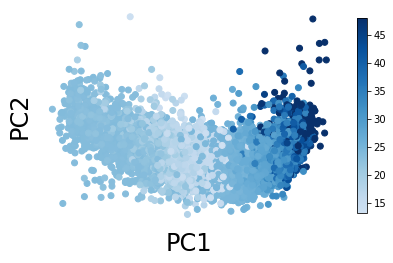

In [126]:
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

In [113]:
elbos['cc'] = traj.elbos

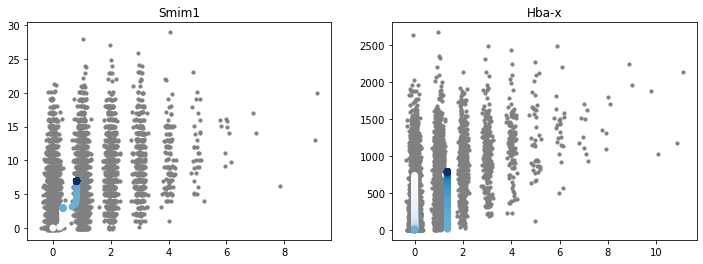

In [114]:
plot_phase(traj,idx=plot_idx,gene_name=fitted_genes);

In [115]:
traj.theta[plot_idx]

array([[1.55433318e-16, 3.47664015e-01, 8.18207041e-01, 2.30092276e+01,
        2.71701967e+00],
       [1.28214923e+00, 8.67398984e-05, 1.36057403e+00, 1.49342533e+02,
        2.57576683e-01]])

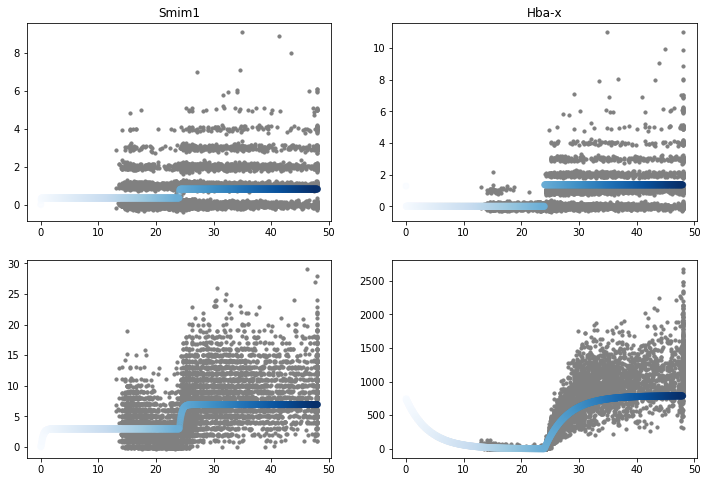

In [116]:
plot_y(traj,X=X,idx=plot_idx,gene_name=fitted_genes);

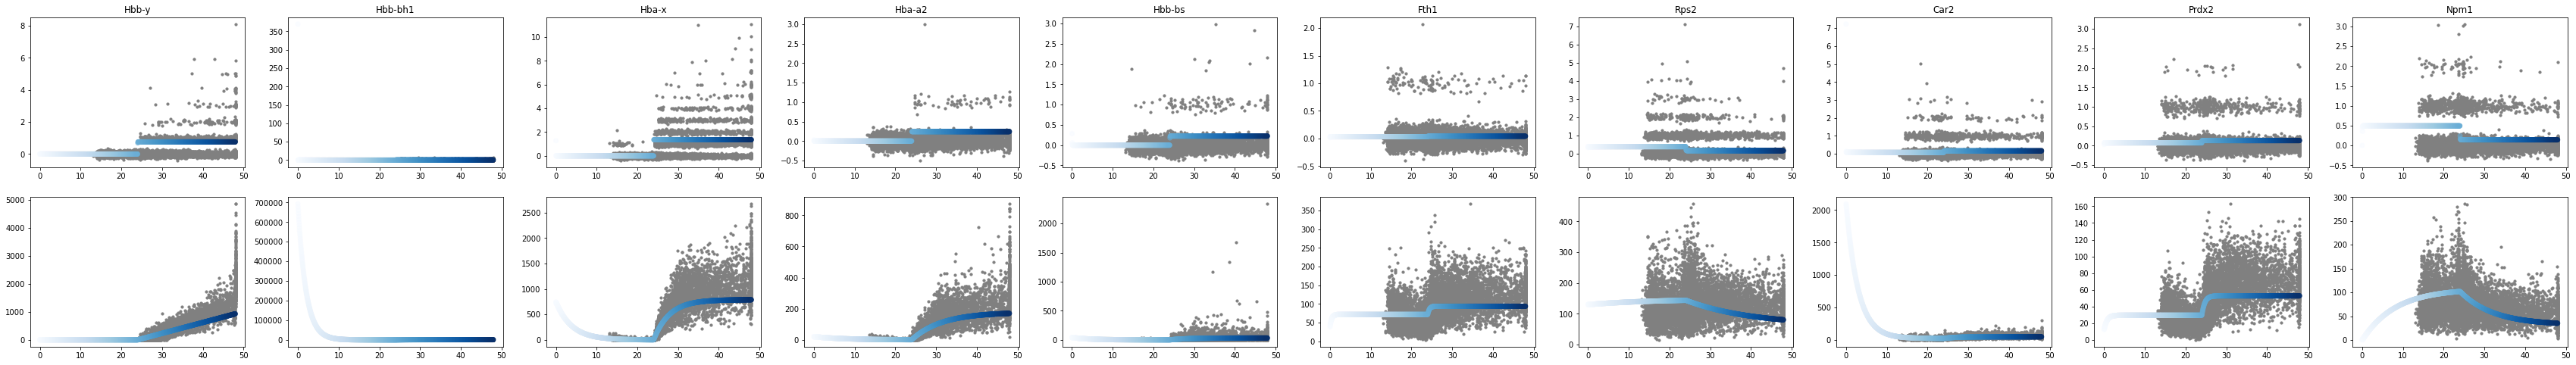

In [117]:
plot_y(traj,X=X,idx=np.arange(10),gene_name=fitted_genes);

[]

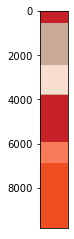

In [118]:
order = np.argsort(traj.Q[:,0]@traj.t)
cluster = np.zeros(data.n_obs)
for i,cell_type in enumerate(cell_types):
    idx = data.obs["celltype"].isin([cell_type])
    cluster[idx] = i
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
fig, ax = plt.subplots(1,1,figsize=(0.5,4))
ax.imshow(cluster[order,None],aspect="auto",cmap=cmap_cluster)
ax.set_xticks([])

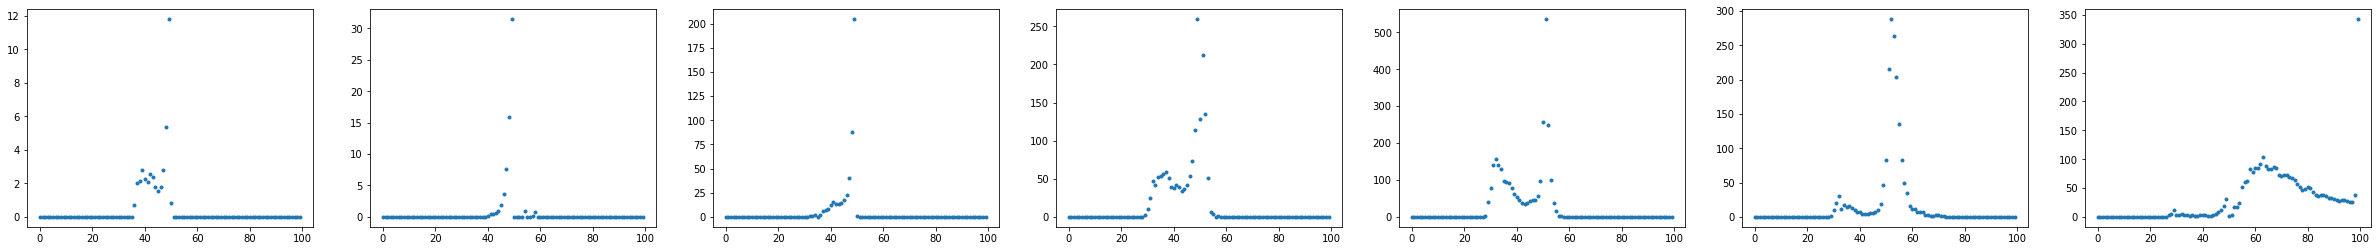

In [119]:
fig, ax = plt.subplots(1,len(stages),figsize=(6*len(stages),4))
for i,stage in enumerate(stages):
    idx = data.obs["stage"].isin([stage])
    ax[i].plot(traj.Q[idx,0].sum(0),'.')

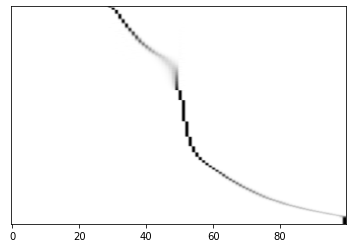

In [120]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax=plot_t(traj,l=0,ax=ax,order_cells=True)
ax.set_yticks([]);

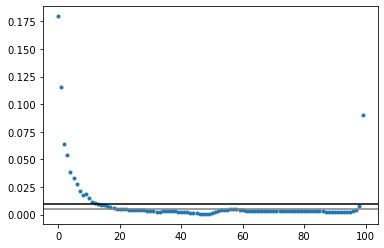

In [101]:
plt.plot(traj.Q[:,0].mean(0),'.')
plt.axhline(y=1/traj.m,c='k')
plt.axhline(y=0.5/traj.m,c='gray')

NameError: name 'p' is not defined

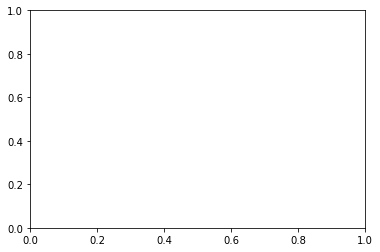

In [102]:
fig,ax = plt.subplots(1,1)
for j in range(p):
    ax.plot(traj.theta[j,[-3,0,1]],'-*',color='gray')
for j in plot_idx:
    ax.plot(traj.theta[j,[-3,0,1]],'-*',color='red')

x_label_list = ['u0', 'α1', 'α2']
ax.set_xticks([0,1,2])
ax.set_xticklabels(x_label_list)
plt.yscale('log')

## Fitting without prior

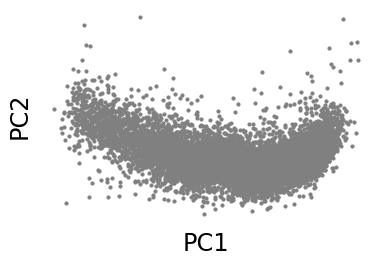

In [14]:
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c='grey',s=10);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);

In [57]:
topo = np.array([[0,1,2]])
tau = (0,1,2)
traj = Trajectory(topo, tau, model="two_species_ss",verbose=1)
traj = traj.fit(X,m=100,n_init=15,epoch=10,parallel=True,n_threads=10,seed=0)

fitting with multiple random initializations
trial 1


100%|██████████| 10/10 [00:05<00:00,  1.73it/s]

trial 2



100%|██████████| 10/10 [00:05<00:00,  1.68it/s]

trial 3



100%|██████████| 10/10 [00:05<00:00,  1.74it/s]

trial 4



100%|██████████| 10/10 [00:05<00:00,  1.69it/s]

trial 5



100%|██████████| 10/10 [00:05<00:00,  1.73it/s]

trial 6



100%|██████████| 10/10 [00:06<00:00,  1.66it/s]

trial 7



100%|██████████| 10/10 [00:05<00:00,  1.74it/s]

trial 8



100%|██████████| 10/10 [00:06<00:00,  1.67it/s]

trial 9



100%|██████████| 10/10 [00:05<00:00,  1.72it/s]

trial 10



100%|██████████| 10/10 [00:06<00:00,  1.66it/s]

trial 11



100%|██████████| 10/10 [00:05<00:00,  1.70it/s]

trial 12



100%|██████████| 10/10 [00:06<00:00,  1.65it/s]

trial 13



100%|██████████| 10/10 [00:05<00:00,  1.73it/s]

trial 14



100%|██████████| 10/10 [00:05<00:00,  1.69it/s]

trial 15



100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


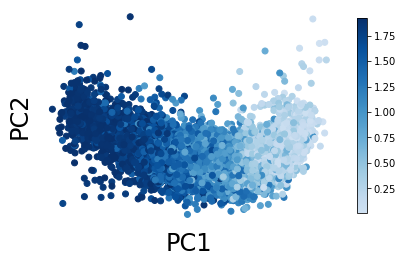

In [58]:
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

elbos['r0'] = traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])] 

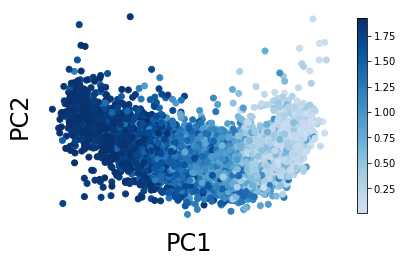

In [59]:
topo = np.array([[0,1,2]])
tau = (0,1,2)
traj = Trajectory(topo, tau, model="two_species_ss",verbose=0)
traj = traj.fit(X,m=100,n_init=15,epoch=10,parallel=True,n_threads=10,seed=1)

cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

elbos['r1'] = traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])] 

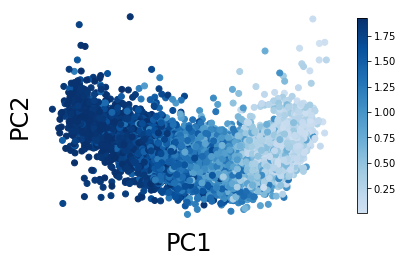

In [60]:
topo = np.array([[0,1,2]])
tau = (0,1,2)
traj = Trajectory(topo, tau, model="two_species_ss",verbose=0)
traj = traj.fit(X,m=100,n_init=15,epoch=10,parallel=True,n_threads=10,seed=2)

cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

elbos['r2'] = traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])] 

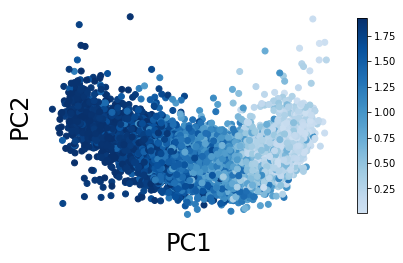

In [61]:
topo = np.array([[0,1,2]])
tau = (0,1,2)
traj = Trajectory(topo, tau, model="two_species_ss",verbose=0)
traj = traj.fit(X,m=100,n_init=15,epoch=10,parallel=True,n_threads=10,seed=3)

cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

elbos['r3'] = traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])] 

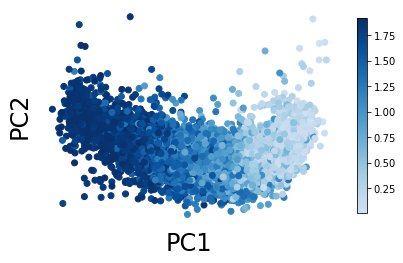

In [62]:
traj = Trajectory(topo, tau, model="two_species_ss",verbose=0)
traj = traj.fit(X,m=100,n_init=15,epoch=10,parallel=True,n_threads=10,seed=4)

cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

elbos['r4'] = traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])] 

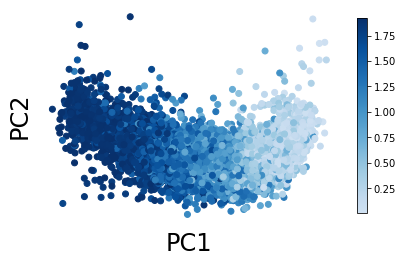

In [63]:
topo = np.array([[0,1,2]])
tau = (0,1,2)
traj = Trajectory(topo, tau, model="two_species_ss",verbose=0)
traj = traj.fit(X,m=100,n_init=15,epoch=10,parallel=True,n_threads=10,seed=5)

cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

elbos['r5'] = traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])] 

In [64]:
for idx in elbos.keys():
    print(idx, elbos[idx][-1])

cf -59.54724714702106
cc -59.54724714702106
r0 -57.17266441139209
r1 -57.169131846180456
r2 -57.16795389073062
r3 -57.17080950605258
r4 -57.169031317290006
r5 -57.16963935301644


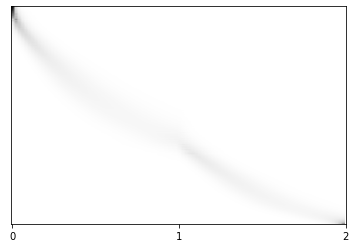

In [30]:
ax = plot_t(traj,l=0,order_cells=True)
x_label_list = ['0', '1', '2']
ax.set_xticks([0,50,100])
ax.set_xticklabels(x_label_list);
ax.set_yticks([]);

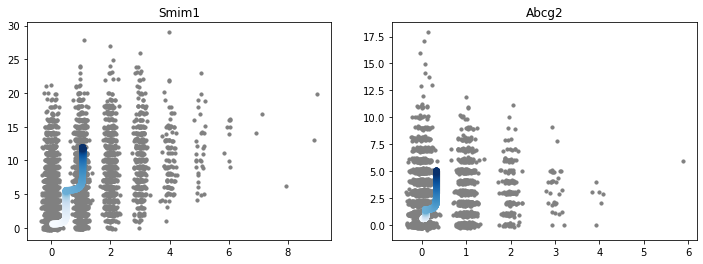

In [32]:
plot_phase(traj,idx=plot_idx,gene_name=fitted_genes);

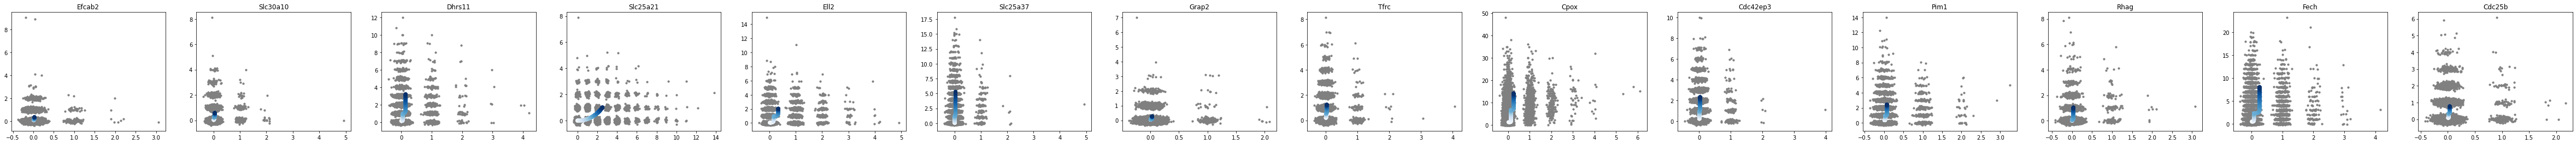

In [34]:
plot_phase(traj,idx=np.arange(14),gene_name=fitted_genes);

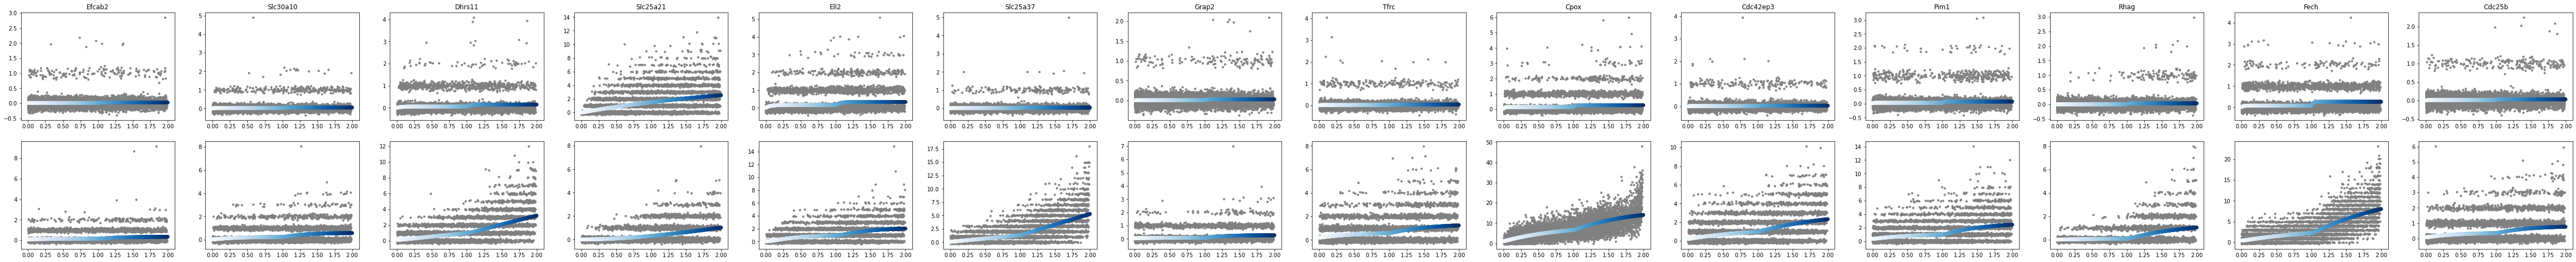

In [35]:
plot_y(traj,idx=np.arange(14),gene_name=fitted_genes);

In [38]:
#from scipy.spatial import distance

#S = data.X.toarray()
#dist = distance.cdist(S, S, 'minkowski', p=1.)

In [39]:
#order = np.argsort(data.obs["t_hat"])
#sorted_dist = dist[order,:][:,order]
#plt.imshow(sorted_dist,aspect="auto");

In [40]:
#order = np.argsort(data.obs["celltype"])
#sorted_dist = dist[order,:][:,order]
#plt.imshow(sorted_dist,aspect="auto");

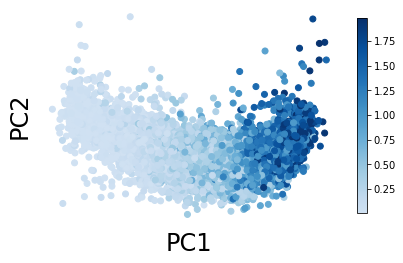

In [40]:
topo = np.array([[0,1,2]])
tau = (0,1,2)
traj_tau = Trajectory(topo, tau, model="two_species_ss_tau",verbose=0)
traj_tau = traj_tau.fit(X,Q=traj.Q,m=100,n_init=10,epoch=10,parallel=True,n_threads=10)

cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj_tau.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

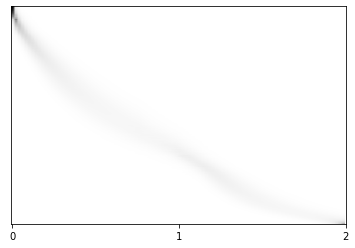

In [41]:
ax = plot_t(traj_tau,l=0,order_cells=True)
x_label_list = ['0', '1', '2']
ax.set_xticks([0,50,100])
ax.set_xticklabels(x_label_list);
ax.set_yticks([]);

(array([ 2.,  0.,  0.,  2.,  3.,  5., 16.,  6.,  3.,  3.]),
 array([0.75562805, 0.79319656, 0.83076507, 0.86833358, 0.90590208,
        0.94347059, 0.9810391 , 1.01860761, 1.05617612, 1.09374462,
        1.13131313]),
 <BarContainer object of 10 artists>)

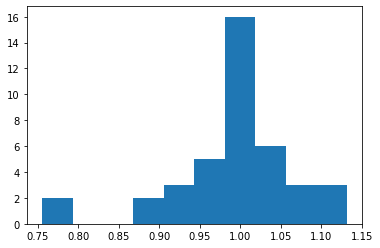

In [43]:
plt.hist(traj_tau.theta[:,3])

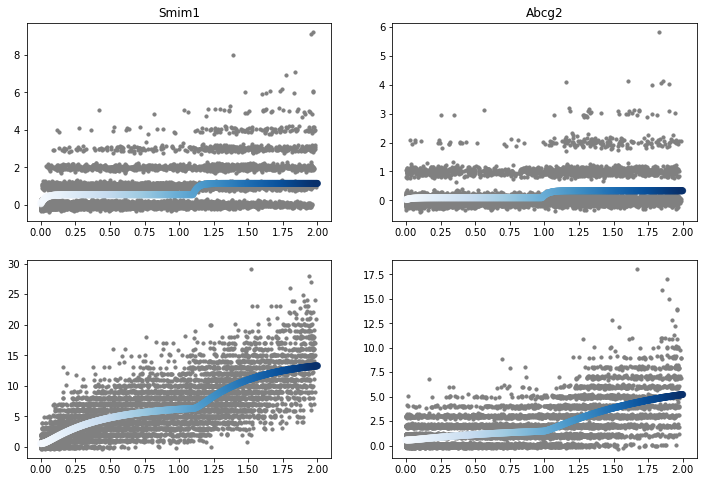

In [42]:
plot_y(traj_tau,idx=plot_idx,gene_name=fitted_genes);

## Coarse clusters

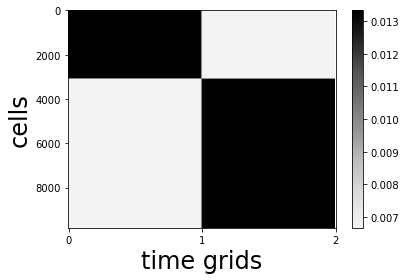

In [55]:
coarse_cell_types = [ ['Blood progenitors 1','Blood progenitors 2'],['Erythroid1','Erythroid2', 'Erythroid3']]
m=100
t_grids=np.linspace(0,2,m)
weight0 = np.ones((data.n_obs,m))
for i,cell_type in enumerate(coarse_cell_types):
    idx = data.obs["celltype"].isin(cell_type)
    weight0[idx,int(i*m/2):int((i+1)*m/2)] += 1
weight0=weight0/weight0.sum(axis=1,keepdims=True)
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
Q0 = weight0[:,None]
ax = plot_t(Q0,order_cells=True)

x_label_list = ['0', '1', '2']
ax.set_xticks([0,50,100])
ax.set_xticklabels(x_label_list)

label_font = '24'
plt.ylabel("cells", fontsize = label_font);
plt.xlabel("time grids", fontsize = label_font);

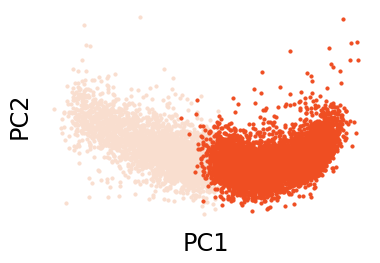

In [57]:
fig, ax = plt.subplots(1,1)
for i,celltype in enumerate(coarse_cell_types):
    idx = data.obs["celltype"].isin(celltype)
    im=ax.scatter(x[idx,0],x[idx,1],c=data.uns['celltype_colors'][4*i],s=10);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);

In [58]:
topo = np.array([[0,1]])
tau = (0,1,2) # ~48 hours
traj = Trajectory(topo, tau, model="two_species_ss",verbose=1)
traj = traj.fit(X,Q=Q0,parallel=True,n_threads=4,epoch=100)

run method fit_warm_start


 31%|███       | 31/100 [00:14<00:33,  2.07it/s]


In [59]:
elbos['cc'] = traj.elbos

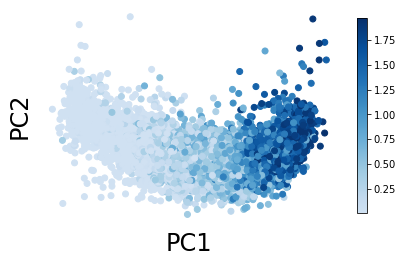

In [60]:
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

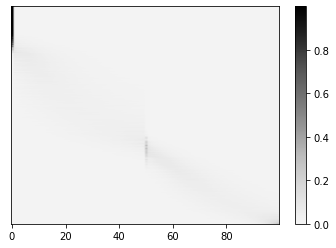

In [61]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax=plot_t(traj.Q[order],l=0,ax=ax,order_cells=False)
ax.set_yticks([]);

In [ ]:
plot_y(traj,idx=np.arange(14),gene_name=fitted_genes)

In [ ]:
plot_phase(traj,idx=np.arange(14),gene_name=fitted_genes)

In [ ]:
plot_mask = fitted_genes.isin(their_genes)
plot_idx = np.arange(len(fitted_genes))[plot_mask]

plot_phase(traj, plot_idx, gene_list, cell_colors='grey')

plot_y(traj, plot_idx, gene_list, cell_colors='grey')

## ELBO plot

In [67]:
for idx in elbos.keys():
    print(idx, np.around(elbos[idx][-1],4))

cf 12.7819
cc 12.192
r2019 13.6206
r2020 13.6221
r2021 13.6337
r2022 13.6174
r2023 13.6352
r2024 13.6345
r 13.6441


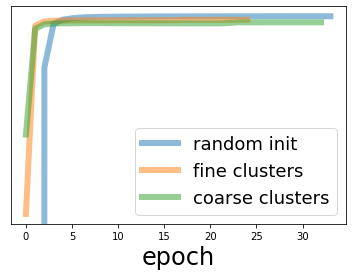

In [62]:
fig, ax = plt.subplots(1,1)
ax.plot(elbos['r'],label="random init",linewidth=6,alpha=0.5);
ax.plot(elbos['cf'],label="fine clusters",linewidth=6,alpha=0.5);
ax.plot(elbos['cc'],label="coarse clusters",linewidth=6,alpha=0.5);
ax.set_yscale('log')
ax.set_xlabel('epoch',fontsize=24)
ax.set_ylabel('relative elbo',fontsize=24)
plt.legend(fontsize=18);
ax.axes.get_yaxis().set_visible(False)

# Synthetic data

In [51]:
Y = traj.get_Y_hat(theta=traj.theta,t=traj.Q[:,0]@traj.t,tau=traj.tau,topo=traj.topo,params=traj.params)
syn_X = np.random.poisson(Y[0])
syn_t = traj.Q[:,0]@traj.t

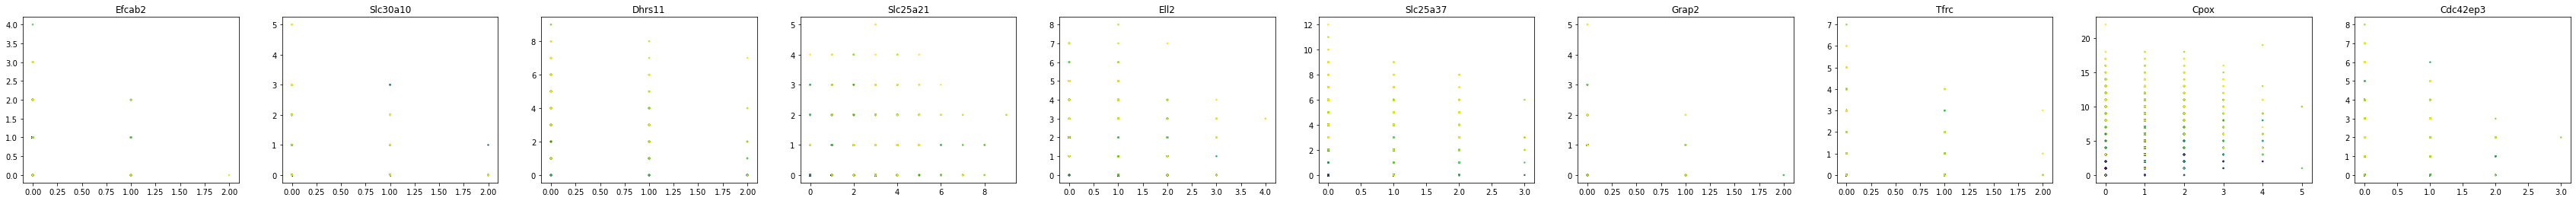

In [52]:
fig, ax = plt.subplots(1,10,figsize=(6*10,4))
for i in range(10):
    ax[i].scatter(syn_X[:,i,0],syn_X[:,i,1],c=syn_t ,s=2)
    ax[i].set_title(fitted_genes[i])

100%|██████████| 5/5 [07:44<00:00, 92.94s/it]


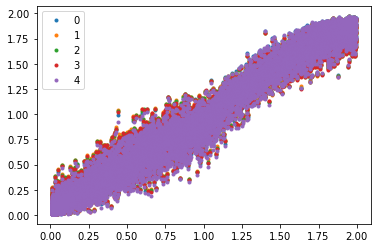

In [55]:
tau = (0,1,2)
topo = np.array([[0,1,2]])
trajs = []
for seed in tqdm(range(5)):
    traj_ = Trajectory(topo, tau,  model="two_species_ss", restrictions={}, verbose=0)
    traj_ = traj_.fit(syn_X, warm_start=False, params=params, n_init=15, perm_theta=False, parallel=True, epoch=10, n_threads=10, seed=seed)
    trajs.append(traj_)
    
    plt.plot(syn_t,traj_.Q[:,0]@traj_.t,'.',label=seed)
plt.legend()